In [ ]:
!git clone https://github.com/VongCanhChi/GANsNRoses.git
%cd GANsNRoses
!pip install tqdm gdown kornia scipy opencv-python dlib moviepy lpips aubio ninja
!pip install --upgrade --no-cache-dir gdown

Cloning into 'GANsNRoses'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (180/180), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 180 (delta 95), reused 87 (delta 37), pack-reused 0
Receiving objects: 100% (180/180), 27.77 MiB | 12.27 MiB/s, done.
Resolving deltas: 100% (95/95), done.
/content/GANsNRoses
     |████████████████████████████████| 474 kB 3.4 MB/s 
     |████████████████████████████████| 53 kB 2.7 MB/s 
     |████████████████████████████████| 479 kB 44.2 MB/s 
     |████████████████████████████████| 108 kB 49.1 MB/s 
  Created wheel for aubio: filename=aubio-0.4.9-cp37-cp37m-linux_x86_64.whl size=390115 sha256=6c1ad2177bf12c5f021b76cff755af760f1e7d47209be10acf96551034b46eb9
  Stored in directory: /root/.cache/pip/wheels/82/d4/6a/930c11ef645b5c5b14e5152ea5030ab1d665593405ca3c5d3e
Successfully built aubio
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... 

In [ ]:
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms, utils
from tqdm import tqdm
torch.backends.cudnn.benchmark = True
import copy
from util import *
from PIL import Image

from model import *
import moviepy.video.io.ImageSequenceClip
import scipy
import cv2
import dlib
import kornia.augmentation as K
from aubio import tempo, source

from IPython.display import HTML
from base64 import b64encode
from google.colab import files

import pickle
from IPython.display import display, clear_output
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [ ]:
device = 'cuda'
latent_dim = 8
n_mlp = 5
num_down = 3

G_A2B = Generator(256, 4, latent_dim, n_mlp, channel_multiplier=1, lr_mlp=.01,n_res=1).to(device).eval()
ensure_checkpoint_exists('GNR_checkpoint.pt')
ckpt = torch.load('GNR_checkpoint.pt', map_location=device)

G_A2B.load_state_dict(ckpt['G_A2B_ema'])


test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), inplace=True)
])

Downloading...
From: https://drive.google.com/uc?id=1sv64BpSdmW08PHWvKOjEVLI7A82V56e9
To: /content/GANsNRoses/GNR_checkpoint.pt
100%|██████████| 317M/317M [00:04<00:00, 70.4MB/s]


Saving mytam.jpg to mytam (2).jpg


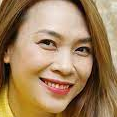

In [ ]:
# upload your own image
uploaded = files.upload()
filepath = list(uploaded.keys())[0]

image = cv2.imread(filepath)
height, width = image.shape[:2]

# Detect with dlib
face_detector = dlib.get_frontal_face_detector()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# grab first face
face = face_detector(gray, 1)[0]

# Face crop with dlib and bounding box scale enlargement
x, y, size = get_boundingbox(face, width, height)
cropped_face = image[y:y+size, x:x+size]
cropped_face = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB)
cropped_face = Image.fromarray(cropped_face)
cropped_face

In [ ]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 200

torch.manual_seed(84986)
with torch.no_grad():
    style = G_A2B.mapping(torch.randn([1000, latent_dim]).to(device)).mean(0, keepdim=True)

real_A = cropped_face
real_A = test_transform(real_A).unsqueeze(0).to(device)
with torch.no_grad():
    A2B_content, _ = G_A2B.encode(real_A)

In [ ]:
!gdown https://drive.google.com/uc?id=1UEEjz9BfwY9d4Pi2is91NdRqAsfX1dPq > latentTagLinearRegression
with open('/content/GANsNRoses/latentTagLinearRegression', 'rb') as f:
    tag_directions_linear = pickle.load(f)
tag_directions = tag_directions_linear

Downloading...
From: https://drive.google.com/uc?id=1UEEjz9BfwY9d4Pi2is91NdRqAsfX1dPq
To: /content/GANsNRoses/latentTagLinearRegression
100% 102k/102k [00:00<00:00, 96.0MB/s]


In [ ]:
!gdown https://drive.google.com/uc?id=1-2E2RqIi1qtDQiin6toAwI8iasCSHkQq > latentTagLassoRegression
with open('/content/GANsNRoses/latentTagLassoRegression', 'rb') as f:
    tag_directions_lasso = pickle.load(f)
tag_directions = tag_directions_lasso

In [ ]:
!gdown https://drive.google.com/uc?id=1--MiXon1lqIQoA2JAM3dI6ySJuARDUe1 > latentTaglogisticClassfiy
with open('/content/GANsNRoses/latentTaglogisticClassfiy', 'rb') as f:
    tag_directions_logistic = pickle.load(f)
tag_directions = tag_directions_logistic

In [ ]:
!gdown https://drive.google.com/uc?id=1-798j2n3NI3-pFW4LIj3PuOFLkiJaXhT > latentTagSVCClassify
with open('/content/GANsNRoses/latentTagSVCClassify', 'rb') as f:
    tag_directions_svc = pickle.load(f)
tag_directions = tag_directions_svc

In [ ]:
!gdown https://drive.google.com/uc?id=1-4Wo2Sb0OeZPZw3iGgODuXPlMWb7aXcg > latentTagSVD
with open('/content/GANsNRoses/latentTagSVD', 'rb') as f:
    tag_directions_svd_file = pickle.load(f)
tag_directions_svd = {}
for key in tag_directions_svd_file.keys():
  tag_directions_svd[key] = tag_directions_svd_file[key][0]
tag_directions_svd['half-closed_eyes'] = tag_directions_svd_file['half-closed_eyes'][3]

In [ ]:
torch.manual_seed(9090)
style = G_A2B.mapping(torch.randn([1, latent_dim]).to(device))

In [ ]:
hair_eyes_only = False
dlatents_prepared = None
projection_in = None

tag_len = {}
for tag in tag_directions:
    tag_len[tag] = np.linalg.norm(np.array(tag_directions[tag])) 
dlatents_gen = style.cpu().detach().numpy()
def modify_and_sample(psi_pre, psi_post, truncate_pre, truncate_post, **kwargs):
    if truncate_pre == True:
        dlatents_mod = truncate(copy.deepcopy(dlatents_gen), psi_pre)
    else:
        dlatents_mod = copy.deepcopy(dlatents_gen)
        
    for tag in kwargs:
        dlatents_mod += tag_directions[tag] * kwargs[tag]  / tag_len[tag] * 5 
    value_widgets["psi_pre"].value = str(round(psi_pre, 2))
    value_widgets["psi_post"].value = str(round(psi_post, 2))
    
    for tag in kwargs:
        tag_value = round((np.dot(dlatents_mod.flatten(), tag_directions[tag].flatten()) / tag_len[tag]), 2)
        value_widgets[tag].value = str(kwargs[tag]) + " | " + str(tag_value)
    
    display_psi = None
    if truncate_post == True:
        display_psi = psi_post

    global dlatents_prepared
    dlatents_prepared = dlatents_mod
    fake_A2B = G_A2B.decode(A2B_content, style, use_mapping=False)
    fake_A2B2 = G_A2B.decode(A2B_content, torch.from_numpy(dlatents_prepared).to(device), use_mapping=False)

    if not projection_in is None:
        pass
    else:
        pass
    #display(im)
    display_image(utils.make_grid(torch.cat([real_A,fake_A2B,fake_A2B2], 0).cpu(), normalize=True, range=(-1, 1)))

psi_slider = widgets.FloatSlider(min = 0.0, max = 1.0, step = 0.01, value = 0.75, continuous_update = False, readout = False)
psi_slider_post = widgets.FloatSlider(min = 0.0, max = 1.0, step = 0.01, value = 0.65, continuous_update = False, readout = False)

modify_tags = list(tag_directions.keys())
tag_widgets = {}
for tag in modify_tags:
    tag_widgets[tag] = widgets.FloatSlider(min = -5.0, max = 5.0, step = 0.005, continuous_update = False, readout = False)
all_widgets = []

sorted_widgets = sorted(tag_widgets.items(), key = lambda x: x[0])
sorted_widgets = [("psi_pre", psi_slider), ("psi_post", psi_slider_post)] + sorted_widgets
value_widgets = {}
for widget in sorted_widgets:
    label_widget = widgets.Label(widget[0])
    label_widget.layout.width = "170px"
    
    value_widget = widgets.Label("0.0+100.0")
    value_widget.layout.width = "150px"
    value_widgets[widget[0]] = value_widget
    
    tag_hbox = widgets.HBox([label_widget, widget[1], value_widget])
    tag_hbox.layout.width = "320px"
    
    all_widgets.append(tag_hbox)

refresh = widgets.Button(description="New Sample")
modify = widgets.Button(description="Mutate")
reset_sliders = widgets.Button(description="Reset")
def new_sample(b):
    global mod_latents
    global dlatents_gen
    
    dlatents_gen = G_A2B.mapping(torch.randn([1, latent_dim]).to(device))
    if psi_slider.value != 1.0:
        psi_slider.value += 0.00000000001
    else:
        psi_slider.value -= 0.00000000001
    
def mutate(b):
    global dlatents_gen
    mod_dlatents_add = np.random.randn(16, 512)
    dlatents_gen += mod_dlatents_add * 0.1
    if psi_slider.value != 1.0:
        psi_slider.value += 0.00000000001
    else:
        psi_slider.value -= 0.00000000001

def reset(b):
    for widget in tag_widgets:
        if not widget in ["truncate_pre", "truncate_post", "psi_pre", "psi_post"]:
            tag_widgets[widget].value = 0.0

def encode(b):
    global dlatents_gen
    file_name = list(b["new"].keys())[0]
    image = PIL.Image.open(io.BytesIO(b["new"][file_name]["content"]))
    dlatents_gen = encode_image(image, encode_iters.value)

    global projection_in
    projection_in = image

    if psi_slider.value != 1.0:
        psi_slider.value += 0.00000000001
    else:
        psi_slider.value -= 0.00000000001
          
truncate_pre = widgets.ToggleButton(value=False, description='Truncate Pre')
truncate_post = widgets.ToggleButton(value=True, description='Truncate Post')
refresh.on_click(new_sample)
modify.on_click(mutate)
reset_sliders.on_click(reset)

upload = widgets.FileUpload(
    description = "Upload and project",
    accept=".png,.jpg,.jpeg"
)
upload.observe(encode, names="value")

encode_iters = widgets.IntSlider(min = 10, max = 2000, step = 1, value=200, continuous_update = False, readout = True)

ui = widgets.Box(all_widgets + [refresh, modify, reset_sliders, truncate_pre, truncate_post, upload, widgets.Label("Iterations"), encode_iters])
tag_widgets["psi_pre"] = psi_slider
tag_widgets["psi_post"] = psi_slider_post

ui.layout.flex_flow = 'row wrap'
ui.layout.display = 'inline-flex'
tag_widgets["truncate_pre"] = truncate_pre
tag_widgets["truncate_post"] = truncate_post
out = widgets.interactive_output(modify_and_sample, tag_widgets)

In [ ]:
display(ui, out)

Box(children=(HBox(children=(Label(value='psi_pre', layout=Layout(width='170px')), FloatSlider(value=0.75, con…

Output()

In [ ]:
# input video
inpath = './samples/tiktok.mp4'
outpath = './samples/output.mp4'

mode = 'eig'
assert mode in ('normal', 'blend', 'beat', 'eig')


# Frame numbers and length of output video
start_frame=0
end_frame=None
frame_num = 0
mp4_fps= 30
faces = None
smoothing_sec=.7
eig_dir_idx = 1 # first eig isnt good so we skip it

frames = []
reader = cv2.VideoCapture(inpath)
num_frames = int(reader.get(cv2.CAP_PROP_FRAME_COUNT))

# get beats from audio
win_s = 512                 # fft size
hop_s = win_s // 2          # hop size

s = source(inpath, 0, hop_s)
samplerate = s.samplerate
o = tempo("default", win_s, hop_s, samplerate)
delay = 4. * hop_s
# list of beats, in samples
beats = []

# total number of frames read
total_frames = 0
while True:
    samples, read = s()
    is_beat = o(samples)
    if is_beat:
        this_beat = int(total_frames - delay + is_beat[0] * hop_s)
        beats.append(this_beat/ float(samplerate))
    total_frames += read
    if read < hop_s: break
#print len(beats)
beats = [math.ceil(i*mp4_fps) for i in beats]


if mode == 'blend':
    shape = [num_frames, 8, latent_dim] # [frame, image, channel, component]
    all_latents = random_state.randn(*shape).astype(np.float32)
    all_latents = scipy.ndimage.gaussian_filter(all_latents, [smoothing_sec * mp4_fps, 0, 0], mode='wrap')
    all_latents /= np.sqrt(np.mean(np.square(all_latents)))
    all_latents = torch.from_numpy(all_latents).to(device)
else:
    all_latents = torch.randn([8, latent_dim]).to(device)
    
if mode == 'eig':
    all_latents = G_A2B.mapping(all_latents)
    
in_latent = all_latents

# Face detector
face_detector = dlib.get_frontal_face_detector()

assert start_frame < num_frames - 1
end_frame = end_frame if end_frame else num_frames

while reader.isOpened():
    _, image = reader.read()
    if image is None:
        break

    if frame_num < start_frame:
        continue
    # Image size
    height, width = image.shape[:2]

    # 2. Detect with dlib
    if faces is None:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = face_detector(gray, 1)
    if len(faces):
        # For now only take biggest face
        face = faces[0]

    # --- Prediction ---------------------------------------------------
    # Face crop with dlib and bounding box scale enlargement
    x, y, size = get_boundingbox(face, width, height)
    cropped_face = image[y:y+size, x:x+size]
    cropped_face = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB)
    cropped_face = Image.fromarray(cropped_face)
    frame = test_transform(cropped_face).unsqueeze(0).to(device)

    with torch.no_grad():
        A2B_content, A2B_style = G_A2B.encode(frame)
        if mode == 'blend':
            in_latent = all_latents[frame_num]
        elif mode == 'normal':
            in_latent = all_latents
        elif mode == 'beat':
            if frame_num in beats:
                in_latent = torch.randn([8, latent_dim]).to(device)
        
        if mode == 'eig':
          fake_A2B = G_A2B.decode(A2B_content, style.to(device), use_mapping=False)
          fake_A2B2 = G_A2B.decode(A2B_content, torch.from_numpy(dlatents_prepared).to(device), use_mapping=False)
        else:
            fake_A2B = G_A2B.decode(A2B_content.repeat(8,1,1,1), in_latent)

        
        
        fake_A2B = torch.cat([frame,fake_A2B[:4],fake_A2B2[:4]], 0)

        fake_A2B = utils.make_grid(fake_A2B.cpu(), normalize=True, range=(-1, 1), nrow=3)


    #concatenate original image top
    fake_A2B = fake_A2B.permute(1,2,0).cpu().numpy()
    frames.append(fake_A2B*255)

    frame_num += 1
        
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(frames, fps=mp4_fps)

# save to temporary file. hack to make sure ffmpeg works
clip.write_videofile('./temp.mp4')

# use ffmpeg to add audio to video
!ffmpeg -i ./temp.mp4 -i $inpath -c copy -map 0:v:0 -map 1:a:0 $outpath -y
!rm ./temp.mp4

/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


[MoviePy] >>>> Building video ./temp.mp4
[MoviePy] Writing video ./temp.mp4


100%|██████████| 320/320 [00:05<00:00, 57.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./temp.mp4 

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enab

In [ ]:
mp4 = open(outpath,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)
